In [23]:
import fundamentalanalysis as fa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import statistics as st
from matplotlib.pyplot import figure

%matplotlib inline 

In [24]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [25]:
api_key = '00ef9804fcde0edd93b1b4821ee2f06a'
# api_key = 'c81352430e2fe3c941faf0814227562b'

data

In [26]:

''' Колонки '''
# ticker = 'ATEX'
ticker = 'AAPL'



''' для фильтрации'''
filt_start_date = '1999'
filt_finish_date = '2022'


''' время '''
stime=f'{str(int(filt_start_date)-1)}-01-01'
ftime='2023-02-01'
period = '1mo'  # '1d' '1wk'

ticker and stock data

In [27]:
def get_data_from_ticker(tick, stime, ftime, interval=period):
    ticker = yf.Ticker(tick)

    df = ticker.history(start=stime, end=ftime, interval=interval)
    x = pd.DataFrame(df)
    x.rename(columns={"Close": tick}, inplace=True)
    z = x.drop(columns=["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"])
    return z

df = get_data_from_ticker(ticker, stime, None, period)
df_market = get_data_from_ticker('^GSPC', stime, None, period)
df.tail(3)

,AAPL
Date,
2022-12-01 00:00:00-05:00,129.731918
2023-01-01 00:00:00-05:00,144.070023
2023-02-01 00:00:00-05:00,151.009995


change index to add in metriks df

In [28]:
def change_index(df):
    df_index = df.index.to_list()
    for i in range(len(df_index)):
        t = df_index[i].date()
        df_index[i] = t.strftime('%Y-%m-%d')
    df['Date_index'] = df_index
    df = df.set_index('Date_index')
    return df

df = change_index(df)
df_market  = change_index(df_market)
df.tail(3)

,AAPL
Date_index,
2022-12-01,129.731918
2023-01-01,144.070023
2023-02-01,151.009995


In [29]:
''' добавляем цифру к году, чтобы видень данные как начало года, а не как факт '''
def change_index_plus_one(df):
    df_index = df.index.to_list()
    for i in range(len(df_index)):
        df_index[i] = str(int(df_index[i])+1)
    df['Date_index'] = df_index
    df = df.set_index('Date_index')
    return df

key_metrics

In [30]:
key_metrics = fa.key_metrics(ticker, api_key, period='annual')
df_key_metr = key_metrics.T
df_key_metr = change_index_plus_one(df_key_metr)
df_key_metr.head(3)

ValueError: This endpoint is only for premium members. Please visit the subscription page to upgrade the plan (Starter or higher) at https://financialmodelingprep.com/developer/docs/pricing

In [9]:
df_key_metr = df_key_metr.loc[filt_finish_date:filt_start_date].copy(deep=True)
index_years = df_key_metr.index.to_list()

In [10]:
def get_price_from_df(df, list_dates):
    new_list = []
    for i in range(len(list_dates)):
        x = int(list_dates[i])
        # x += 1
        x = str(x)
        r = df.loc[f'{x}-01-01']
        r = float(r)
        new_list.append(r)
        
    return new_list
        
stock_year_prices = get_price_from_df(df, index_years)
stock_year_market_prices = get_price_from_df(df_market, index_years)

In [11]:
df_key_metr[ticker] = list(stock_year_prices)
df_key_metr['SNP'] = list(stock_year_market_prices)
df_key_metr.drop('period', axis=1, inplace=True)

add_percent_columns

In [12]:
def change_percent_all_columns(df):
    x = df.columns.to_list()
    for i in range(len(x)):
        v = df[x[i]].to_list()
        l = []
        for y in range(len(v)):
            try:
                # if y != len(v):
                #     vv = (v[y] / (v[y+1] / 100)) - 100
                #     l.append(vv)
                #     # print(vv)
                if y != len(v):
                    if v[y] < 0 and v[y+1] > 0:
                        l.append('Minus')
                    elif v[y] > 0 and v[y+1] < 0:
                        l.append('Plus')
                    else:
                        vv = (v[y] / (v[y+1] / 100)) - 100
                        l.append(vv)  
                else:
                    vv = 0
                    l.append(vv)
                    # print(vv)
            except:
                l.append(0)
        df[f'change % {x[i]}'] = l
    return df

df_with_changes_key = change_percent_all_columns(df_key_metr)

Vizualization key_metrics

In [13]:
df_with_changes_key = df_with_changes_key.reindex(index=df_with_changes_key.index[::-1])

In [14]:
df_test = df_with_changes_key[[ticker, f'change % {ticker}']]
df_test

,AAPL,change % AAPL
Date_index,,
1999,0.312995,0.000000
2000,0.788424,151.896532
2001,0.328669,-58.313228
2002,0.375708,14.312203
2003,0.218251,-41.909332
2004,0.342879,57.102709
2005,1.168767,240.868774
2006,2.295284,96.385006
2007,2.605942,13.534632


In [17]:
def get_data_from_ticker_wuth_up_end(tick, s_date, interval='1mo'):

    f_date = str(int(s_date[:4]) + 1)

    ticker = yf.Ticker(tick)

    df = ticker.history(start=s_date, end=f'{f_date}{s_date[4:]}', interval=interval)
    x = pd.DataFrame(df)
    x.rename(columns={"Close": tick}, inplace=True)
    z = x.drop(columns=["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"])
    return z

x = get_data_from_ticker_wuth_up_end('AAPL', '2017-11-03')
x

,AAPL
Date,
2017-12-01 00:00:00-05:00,40.168854
2018-01-01 00:00:00-05:00,39.741608
2018-02-01 00:00:00-05:00,42.279007
2018-03-01 00:00:00-05:00,39.987053
2018-04-01 00:00:00-04:00,39.386459
2018-05-01 00:00:00-04:00,44.536770
2018-06-01 00:00:00-04:00,44.287441
2018-07-01 00:00:00-04:00,45.526752
2018-08-01 00:00:00-04:00,54.460316


In [15]:
''' necessary columns '''

km0 = f'{ticker}'
km1 = f'change % {ticker}'
km2 = 'SNP'
km3 = 'change % SNP'
km4 = 'change % debtToAssets'

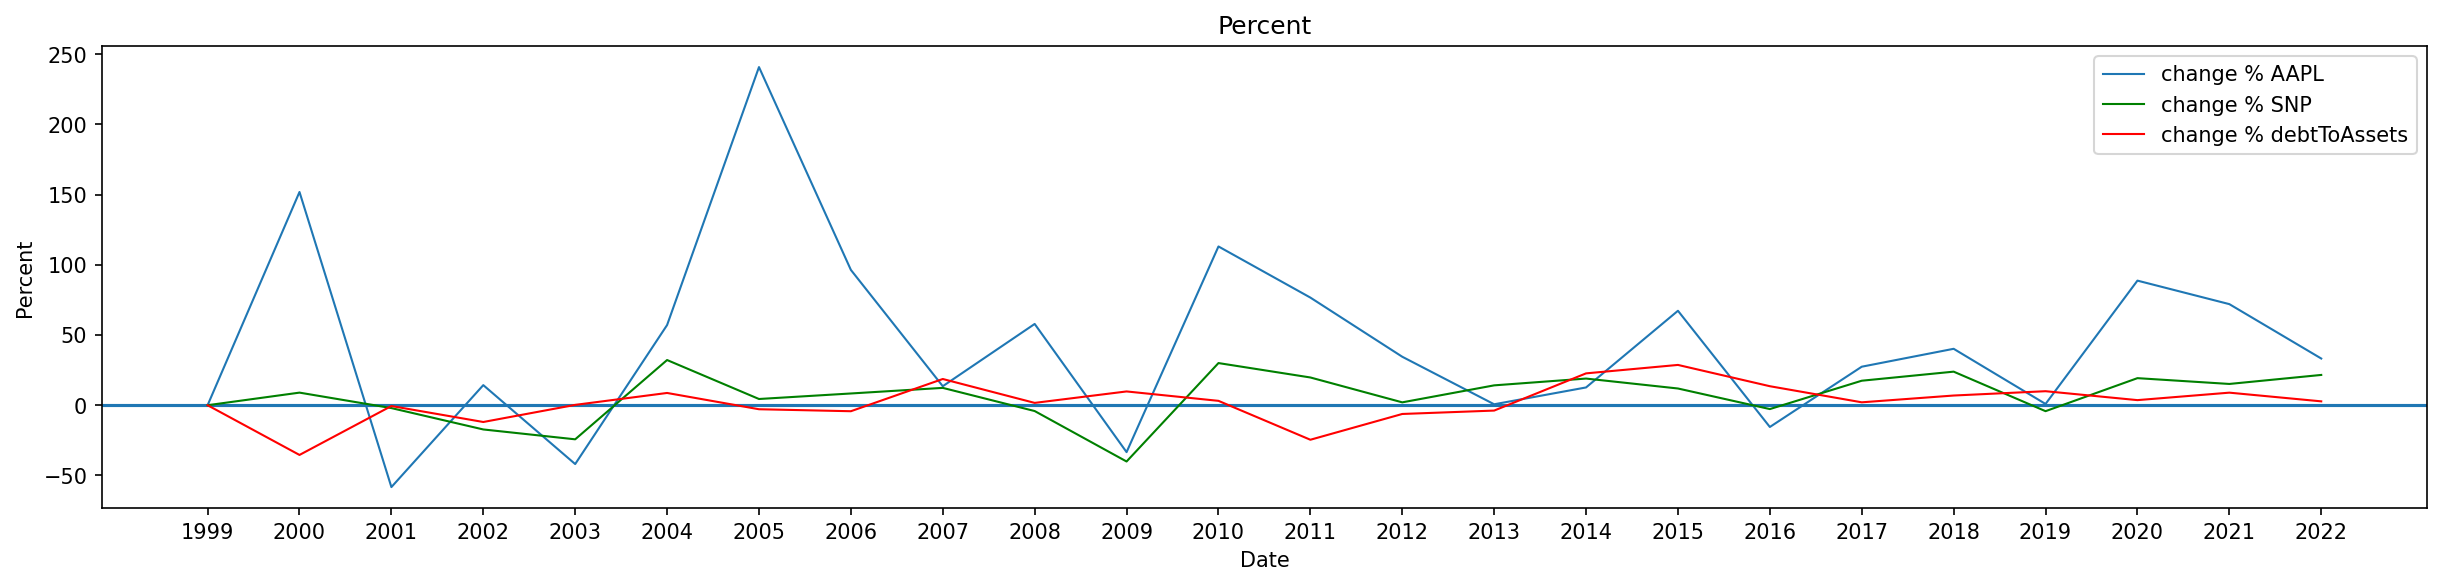

In [16]:
# plot size
figure(figsize=(20,4), dpi=150)
plt.axhline(y=0, linestyle='-')


# Set the title and axis labels
plt.title('Percent')
plt.xlabel('Date')
plt.ylabel('Percent')


# Plot 
plt.plot(df_with_changes_key[km1],lw=1, label=km1)
plt.plot(df_with_changes_key[km3],'g',lw=1, label=km3)
plt.plot(df_with_changes_key[km4],'r',lw=1, label=km4)

# Add a legend to the axis
plt.legend()

plt.show()